# Exploring `build_renewable_profiles.py` outputs

This jupyter notebook analyse the `build_renewable_profiles.py` **outputs**. Outputs are timeseries of wind or solar power plants as well as the resource potential. There are two types of **potentials**, 
- technical installable power potential [MW] which does not need profiles (area demand per tech. MW/km^2 * general available area m^2 * availability factor) 
- technical 'resource' energy potential [MWh] which needs hourly per unit profiles & the above power potential

This notebook looks at both.

The `pypsa-africa/Snakefile` explicitly list in the **rule** what goes into the function `build_renewable_profiles.py` and what goes out (`build_renewable_profiles_{technology}.nc`). So to create the renewable timeseries, we need to provide:
- the base_network
- natura raster, areas where renewables are excluded i.e. areas under protection (generated in `build_natura_raster`)
- copernicus, global land cover data (classifies land data)
- gebco, bathemetry data (deepness of sea)
- cutout, environmental data timeseries such as wind speed and irradiation
```
rule build_renewable_profiles:
    input:
        base_network="networks/base.nc",
        natura="resources/natura.tiff",
        copernicus="data/raw/copernicus/PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif",
        gebco="data/raw/gebco/GEBCO_2021_TID.nc",
        country_shapes='resources/country_shapes.geojson',
        offshore_shapes='resources/offshore_shapes.geojson',
        regions=lambda w: ("resources/regions_onshore.geojson"
                                   if w.technology in ('onwind', 'solar', "hydro")
                                   else "resources/regions_offshore.geojson"),
        cutout=lambda w: "cutouts/" + config["renewable"][w.technology]['cutout'] + ".nc",
    output: profile="resources/profile_{technology}.nc",
    log: "logs/build_renewable_profile_{technology}.log"
    benchmark: "benchmarks/build_renewable_profiles_{technology}"
    threads: ATLITE_NPROCESSES
    resources: mem=ATLITE_NPROCESSES * 5000
    script: "scripts/build_renewable_profiles.py"
```


Before analysing the outputs of add_electricity.py check that:
- `pypsa-africa` environment (/kernel) in jupyter notebook  is active and updated
- root folder where pypsa-africa is installed is named "pypsa-africa"
- or rename the below `sets_path_to_root("<folder_name>")` accordingly

In [1]:
import os
import sys

sys.path.append("../")  # to import helpers
from scripts._helpers import sets_path_to_root

sets_path_to_root("pypsa-africa")

This is the repository path:  /home/max/OneDrive/PHD-Flexibility/07_pypsa-africa/0github/pypsa-africa/pypsa-africa
Had to go 1 folder(s) up.


A jupyter notebook requires the user to import all they need. So we need to import all the required dependencies from the `pypsa-africa` environment:

In [2]:
import atlite
import cartopy.crs as ccrs
import cartopy
import xarray as xr
import geopandas as gpd

# import holoviews as hv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import pypsa
import shutil
from rasterio.plot import show
from atlite.gis import shape_availability, ExclusionContainer


plt.rcParams["figure.figsize"] = [7, 7]
%matplotlib inline

## Generate profiles (if not already available)

If you don't have the renewable profiles such as:
- `resources/profile_solar.nc`
- `resources/profile_onwind.nc`
- `resources/profile_offwind-ac.nc`

you could try to generate them from the terminal. In this case set the path so that you are located at ~/pypsa-africa. Once you are there, use the command:

```
snakemake -j 1 resources/profile_{technology}.nc
```

replace {technology} for the timeseries of interest.

## Let's open the profiles
The `build_renewable_profiles` for each technology are stored in the `resources` folder. We read first the path and open then with xarray the .nc file. As you can see there is quite a lot data available.  What you should note is that only the `potential` is grided (can be shown in a nice raster on a map). From the `profiles` we can only retrieve timeseries data without mapping it.

In [3]:
solar_path = os.path.realpath("resources") + "/profile_solar.nc"
solar = xr.open_dataset(solar_path)
solar

wind_path = os.path.realpath("resources") + "/profile_onwind.nc"
wind = xr.open_dataset(wind_path)
wind

<xarray.Dataset>
Dimensions:           (time: 8760, bus: 221, y: 44, x: 44)
Coordinates:
  * time              (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00
  * bus               (bus) object '0' '2' '3' '4' ... '250' '251' '252' '253'
  * y                 (y) float64 1.5 1.8 2.1 2.4 2.7 ... 13.5 13.8 14.1 14.4
  * x                 (x) float64 2.1 2.4 2.7 3.0 3.3 ... 14.1 14.4 14.7 15.0
Data variables:
    profile           (time, bus) float64 ...
    weight            (bus) float64 ...
    p_nom_max         (bus) float64 ...
    potential         (y, x) float64 ...
    average_distance  (bus) float64 ...

### Technical installable power potential [GW]

Text(53.5, 0.5, 'latitude (epsg:4326)')

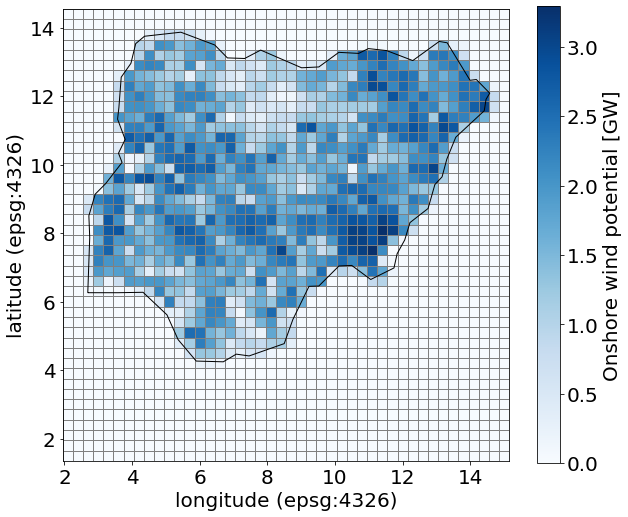

In [4]:
# beauty therapy for plots
plt.rcParams.update({"font.size": 20})
fig, ax = plt.subplots(figsize=(10, 10))

# onshore potential raster
(wind.potential / 1000).plot(
    ax=ax,
    cmap="Blues",
    edgecolor="grey",
    linestyle=":",
    add_colorbar=True,
    cbar_kwargs={"shrink": 0.84, "label": "Onshore wind potential [GW]"},
)

# black edge around nigeria
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries = ["Nigeria"]
shapes = world[world.name.isin(countries)].set_index("name")
shapes.loc[["Nigeria"]].plot(ax=ax, edgecolor="k", color="None")

# labels
plt.xlabel("longitude (epsg:4326)")
plt.ylabel("latitude (epsg:4326)")

# plt.savefig("rasterized-onshore-wind-potential.pdf", bbox_inches='tight')

Text(53.5, 0.5, 'latitude (epsg:4326)')

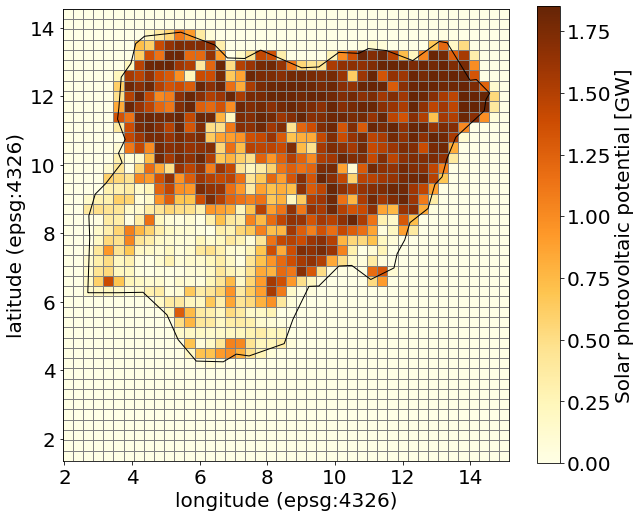

In [5]:
# beauty therapy for plots
plt.rcParams.update({"font.size": 20})
fig, ax = plt.subplots(figsize=(10, 10))

# onshore potential raster
(solar.potential / 1000).plot(
    ax=ax,
    cmap="YlOrBr",
    edgecolor="grey",
    linestyle=":",
    add_colorbar=True,
    cbar_kwargs={"shrink": 0.84, "label": "Solar photovoltaic potential [GW]"},
)

# black edge around nigeria
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries = ["Nigeria"]
shapes = world[world.name.isin(countries)].set_index("name")
shapes.loc[["Nigeria"]].plot(ax=ax, edgecolor="k", color="None")

# labels
plt.xlabel("longitude (epsg:4326)")
plt.ylabel("latitude (epsg:4326)")

# plt.savefig("rasterized-solar-wind-potential.pdf", bbox_inches='tight')

### Technical installable potential in bus regions. Provided by Fabian Neumann.

In [1]:
def plot_map(data, cmap, projection, voronoi=None, title=None, filename=None):
    fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={"projection": projection})
    data.plot.imshow(
        ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, label="potential [MW]"
    )
    # contourf
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS.with_scale("110m"))
    ax.set_extent([-18, -35, 53, 37], crs=ccrs.PlateCarree())
    resource_path = os.path.realpath("resources")
    if voronoi == "onshore":
        br = gpd.read_file(f"{resource_path}/regions_{voronoi}.geojson")
        br.plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            facecolor="none",
            linewidth=0.25,
            edgecolor="k",
        )
    elif voronoi == "offshore":
        br = gpd.read_file(f"{resource_path}/regions_{voronoi}.geojson")
        br.plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            facecolor="none",
            linewidth=0.25,
            edgecolor="k",
        )

    if title is not None:
        plt.title(title)

    if filename is not None:
        plt.savefig(filename, layout="tight", dpi=600)

In [ ]:
plot_map(
    wind.potential,
    "Blues",
    ccrs.Orthographic(),
    voronoi="onshore",
    title="Onshore Wind Geographic Potential [MW]",
    filename="onwind-gridcell.png",
)

In [ ]:
plot_map(
    solar.potential,
    "OrRd",
    ccrs.Orthographic(),
    voronoi="onshore",
    title="Solar Geographic Potential [MW]",
    filename="solar-gridcell.png",
)

### Technical 'resource' energy potential [TWh]

In [6]:
technical_solar_potential_twh = (
    sum(solar["p_nom_max"] * solar["profile"]).sum() / 10**6
)  # MWh to TWH conversion
technical_wind_potential_twh = (
    sum(wind["p_nom_max"] * wind["profile"]).sum() / 10**6
)  # MWh to TWH conversion

print(
    f"Technical solar potential: {technical_solar_potential_twh.values} \n",
    f"Technical wind potential: {technical_wind_potential_twh.values}",
)

Technical solar potential: 1282.6945422916733 
 Technical wind potential: 997.3269398046117


## Timeseries
Timeseris plots are helpful to analyse the seasonality and general variability. Below we show how you could plot some of these.

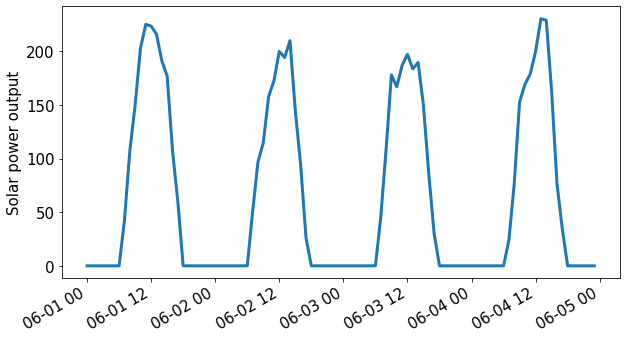

In [7]:
plt.rcParams.update({"font.size": 15})
fig, ax = plt.subplots(figsize=(10, 5))

# max_installable_capacity [MX] * profiles [p.u.]
solar_profile_mw = solar["p_nom_max"] * solar["profile"]

solar_profile_mw.sel(bus="0", time=slice("2013-06-01", "2013-06-04")).plot(
    ax=ax, linewidth=3
)
ax.set_xlabel(None)
ax.set_ylabel("Solar power output")
ax.set_title(None)

plt.savefig("solar-power-profile.pdf", bbox_inches="tight")

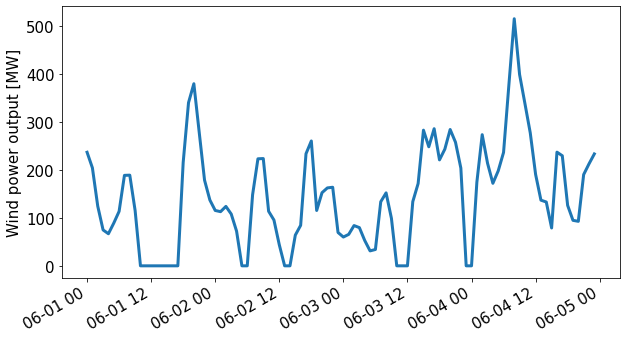

In [8]:
plt.rcParams.update({"font.size": 15})
fig, ax = plt.subplots(figsize=(10, 5))

# max_installable_capacity [MX] * profiles [p.u.]
wind_profile_mw = wind["p_nom_max"] * wind["profile"]

wind_profile_mw.sel(bus="0", time=slice("2013-06-01", "2013-06-04")).plot(
    ax=ax, linewidth=3
)
ax.set_xlabel(None)
ax.set_ylabel("Wind power output [MW]")
ax.set_title(None)

plt.savefig("onshore-wind-power-profile.pdf", bbox_inches="tight")

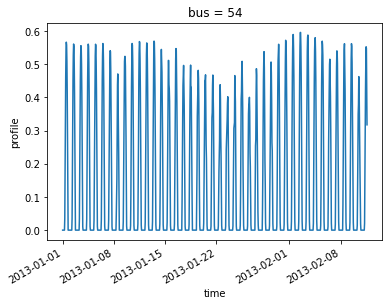

In [9]:
plt.rcParams.update({"font.size": 10})
solar["profile"].isel(bus=sum(range(10)), time=range(0, 1000)).plot()

## Open hydro profile and plot

In [10]:
# res_t_path_h = os.path.realpath("resources") + "/profile_hydro.nc"
# res_h = xr.open_dataset(res_t_path_h)

In [11]:
# res_h.inflow.plot.line(x="time")